In [2]:
import os
if not os.path.exists("AbandonoEmpleados.zip"):
    !wget https://uploads.teachablecdn.com/attachments/pkk4eIy8RlGMPDA32H21_AbandonoEmpleados.zip -O AbandonoEmpleados.zip

!unzip AbandonoEmpleados.zip

^C


In [ ]:
!pip install xgboost lightgbm catboost 
!pip install ipywidgets scikit-optimize

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

/home/brian/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Cargamos los datos y empezamos a explorarlos para ver que es lo que tenemos y que se puede predecir.

**Se tiene la información de que son datos del último año**

Em principio nos interesa predecir el abandono de los empleados.

In [2]:
df = pd.read_csv("AbandonoEmpleados.csv", sep=";",index_col="id", na_values="#N/D")
df

edad abandono             viajes            departamento  \
id                                                               
1       41      Yes      Travel_Rarely                   Sales   
2       49       No  Travel_Frequently  Research & Development   
4       37      Yes      Travel_Rarely  Research & Development   
5       33       No  Travel_Frequently  Research & Development   
7       27       No      Travel_Rarely  Research & Development   
...    ...      ...                ...                     ...   
2061    36       No  Travel_Frequently  Research & Development   
2062    39       No      Travel_Rarely  Research & Development   
2064    27       No      Travel_Rarely  Research & Development   
2065    49       No  Travel_Frequently                   Sales   
2068    34       No      Travel_Rarely  Research & Development   

      distancia_casa      educacion        carrera  empleados  \
id                                                              
1                  1  Universitaria  Life Sciences          1   
2                  8     Secundaria  Life Sciences          1   
4                  2     Secundaria          Other          1   
5                  3  Universitaria  Life Sciences          1   
7                  2  Universitaria        Medical          1   
...              ...            ...            ...        ...   
2061              23         Master        Medical          1   
2062               6     Secundaria        Medical          1   
2064               4         Master  Life Sciences          1   
2065               2     Secundaria        Medical          1   
2068               8            NaN        Medical          1   

     satisfaccion_entorno  sexo  ... satisfaccion_companeros  horas_quincena  \
id                               ...                                           
1                   Media   3.0  ...                    Baja              80   
2                    Alta   2.0  ...                Muy_Alta              80   
4                Muy_Alta   2.0  ...                   Media              80   
5                Muy_Alta   3.0  ...                    Alta              80   
7                    Baja   3.0  ...                Muy_Alta              80   
...                   ...   ...  ...                     ...             ...   
2061                 Alta   4.0  ...                    Alta              80   
2062             Muy_Alta   2.0  ...                    Baja              80   
2064                Media   4.0  ...                   Media              80   
2065             Muy_Alta   NaN  ...                Muy_Alta              80   
2068                Media   4.0  ...                    Baja              80   

     nivel_acciones anos_experiencia num_formaciones_ult_ano  conciliacion  \
id                                                                           
1                 0                8                       0           NaN   
2                 1               10                       3           NaN   
4                 0                7                       3           NaN   
5                 0                8                       3           NaN   
7                 1                6                       3           NaN   
...             ...              ...                     ...           ...   
2061              1               17                       3           NaN   
2062              1                9                       5           NaN   
2064              1                6                       0           NaN   
2065              0               17                       3           NaN   
2068              0                6                       3      Muy_Alta   

      anos_compania anos_en_puesto anos_desde_ult_promocion  \
id                                                            
1                 6            NaN                        0   
2                10            NaN                      

# Bussines Analytics

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 2068
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1470 non-null   int64  
 1   abandono                  1470 non-null   object 
 2   viajes                    1470 non-null   object 
 3   departamento              1470 non-null   object 
 4   distancia_casa            1470 non-null   int64  
 5   educacion                 1369 non-null   object 
 6   carrera                   1470 non-null   object 
 7   empleados                 1470 non-null   int64  
 8   satisfaccion_entorno      1470 non-null   object 
 9   sexo                      1271 non-null   float64
 10  implicacion               1452 non-null   object 
 11  nivel_laboral             1470 non-null   int64  
 12  puesto                    1470 non-null   object 
 13  satisfaccion_trabajo      1394 non-null   object 
 14  estado_civil 

## Analisis de Nulos

In [4]:
print(df.shape)
display(df.isna().sum().sort_values(ascending=False))

(1470, 31)


anos_en_puesto              1238
conciliacion                1011
sexo                         199
educacion                    101
satisfaccion_trabajo          76
implicacion                   18
edad                           0
nivel_acciones                 0
evaluacion                     0
satisfaccion_companeros        0
horas_quincena                 0
anos_experiencia               0
horas_extra                    0
num_formaciones_ult_ano        0
anos_compania                  0
anos_desde_ult_promocion       0
incremento_salario_porc        0
salario_mes                    0
mayor_edad                     0
num_empresas_anteriores        0
abandono                       0
estado_civil                   0
puesto                         0
nivel_laboral                  0
satisfaccion_entorno           0
empleados                      0
carrera                        0
distancia_casa                 0
departamento                   0
viajes                         0
anos_con_m

**Conclusiones**
Lo bueno es que la mayoria de los features no tiene nulos.

Hay features que tienen demasiados nulos, presentan mucha falta de informacion pero no son tan importantes.

* anos_en_puesto y conciliacion tienen demasiados nulos -> los elimino
* sexo, educacion, satisfaccion_trabajo,implicacion no tienen tantos nulos -> imputarlos tras EDA

In [5]:
df = df.drop(columns=["anos_en_puesto", "conciliacion"])
df.head()

edad abandono             viajes            departamento  distancia_casa  \
id                                                                             
1     41      Yes      Travel_Rarely                   Sales               1   
2     49       No  Travel_Frequently  Research & Development               8   
4     37      Yes      Travel_Rarely  Research & Development               2   
5     33       No  Travel_Frequently  Research & Development               3   
7     27       No      Travel_Rarely  Research & Development               2   

        educacion        carrera  empleados satisfaccion_entorno  sexo  ...  \
id                                                                      ...   
1   Universitaria  Life Sciences          1                Media   3.0  ...   
2      Secundaria  Life Sciences          1                 Alta   2.0  ...   
4      Secundaria          Other          1             Muy_Alta   2.0  ...   
5   Universitaria  Life Sciences          1             Muy_Alta   3.0  ...   
7   Universitaria        Medical          1                 Baja   3.0  ...   

   incremento_salario_porc  evaluacion satisfaccion_companeros horas_quincena  \
id                                                                              
1                       11        Alta                    Baja             80   
2                       23    Muy_Alta                Muy_Alta             80   
4                       15        Alta                   Media             80   
5                       11        Alta                    Alta             80   
7                       12        Alta                Muy_Alta             80   

   nivel_acciones  anos_experiencia  num_formaciones_ult_ano anos_compania  \
id                                                                           
1               0                 8                        0             6   
2               1                10                        3            10   
4               0                 7                        3             0   
5               0                 8                        3             8   
7               1                 6                        3             2   

   anos_desde_ult_promocion  anos_con_manager_actual  
id                                                    
1                         0                        5  
2                         1                        7  
4                         0                        0  
5                         3                        0  
7                         2                        2  

[5 rows x 29 columns]

Divido el EDA en dos partes:
1. EDA de variables categoricas
2. EDA de variables numericas

## EDA VARIABLES CATEGORICAS

In [6]:
def plot_categoric_eda(cat):

    filas = (cat.shape[1] +1) // 2 #equivalente a ceil

    fig, axs = plt.subplots(filas, 2,  figsize = (16, filas*6))

    #Aplanamos los axs para iterarlos.

    ax = axs.flat

    for idx, variable in enumerate(cat):
        cat[variable].value_counts().plot.barh(ax = ax[idx])
        ax[idx].set_title(variable, fontsize=12, fontweight = "bold")
        ax[idx].tick_params(labelsize=12)

    plt.suptitle("Distribución de variables categóricas", fontsize=16, fontweight="bold", y=0.9)
    plt.show()

Tambien quiero analizar si el sexo tiene alguna influencia sobre el despidos

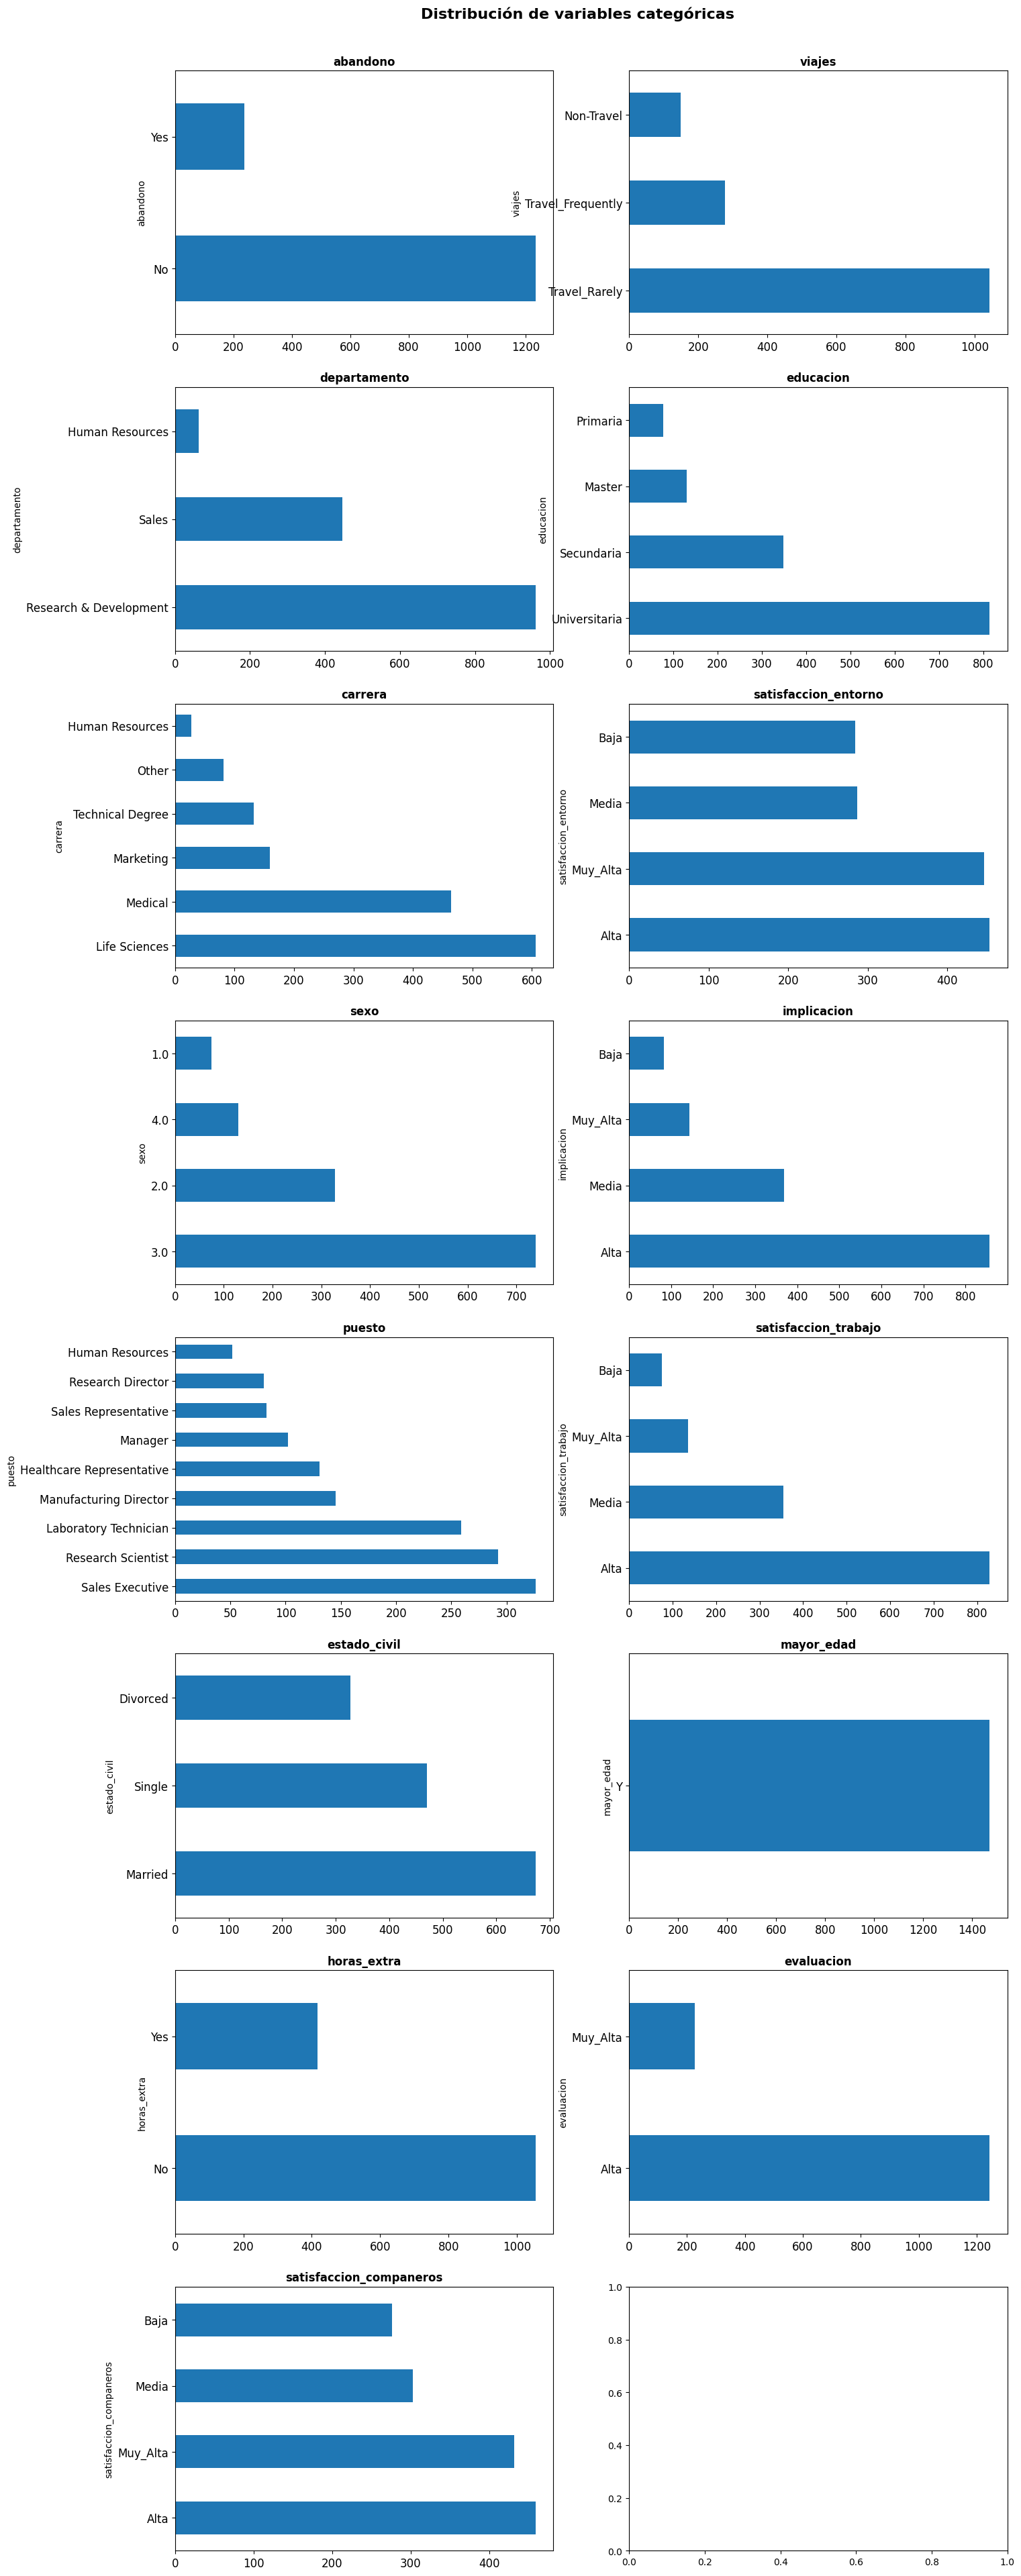

In [7]:
df["sexo"] = df["sexo"].astype("object")
plot_categoric_eda(df.select_dtypes("object"))
#Variables como sexo y demas tambien son categoricas, pero no importa, igual seran analizados.

**Conlusiones**
* mayor_edad solo tiene un valor (no aporta info.) -> eliminar.
* sexo no tiene informacion sobre sus clases       -> eliminar.
* Sobre las imputaciones pendientes de vartiables categoridcas:
  - educación: imputar 'Universitaria'
  - satisfacion_trabajo: imputar por 'alta'
  - implicación: imputar por 'Alta'

  > Nota: tambien puedo asignar aleatoriamente de a cuerdo a la frecuencia de las clases para cada feature.
  > En este caso las clases estan muy desbalanceadas por lo que es mas facil poner la clases de mayor frecuencia.

In [8]:
df.drop(columns=["mayor_edad", "sexo"], inplace=True)


df["educacion"]             = df["educacion"].fillna("Universitaria")

df["satisfaccion_trabajo"]  = df["satisfaccion_trabajo"].fillna("Alta")

df["implicacion"]           = df["implicacion"].fillna("Alta")

## EDA VARIABLES NUMERICAS

In [9]:
def estadisticos(num):
    estadisticos = num.describe().T
    estadisticos['median'] = num.median()
    #reordeno para que la mediana este alado de la media.
    estadisticos = estadisticos.iloc[:, [0,1,8,2,3,4,5,6,7]]
    return(estadisticos)

In [10]:
estadisticos(df.select_dtypes("number"))

count         mean  median          std     min  \
edad                      1470.0    36.923810    36.0     9.135373    18.0   
distancia_casa            1470.0     9.192517     7.0     8.106864     1.0   
empleados                 1470.0     1.000000     1.0     0.000000     1.0   
nivel_laboral             1470.0     2.063946     2.0     1.106940     1.0   
salario_mes               1470.0  6502.931293  4919.0  4707.956783  1009.0   
num_empresas_anteriores   1470.0     2.693197     2.0     2.498009     0.0   
incremento_salario_porc   1470.0    15.209524    14.0     3.659938    11.0   
horas_quincena            1470.0    80.000000    80.0     0.000000    80.0   
nivel_acciones            1470.0     0.793878     1.0     0.852077     0.0   
anos_experiencia          1470.0    11.279592    10.0     7.780782     0.0   
num_formaciones_ult_ano   1470.0     2.799320     3.0     1.289271     0.0   
anos_compania             1470.0     7.008163     5.0     6.126525     0.0   
anos_desde_ult_promocion  1470.0     2.187755     1.0     3.222430     0.0   
anos_con_manager_actual   1470.0     4.123129     3.0     3.568136     0.0   

                             25%     50%     75%      max  
edad                        30.0    36.0    43.0     60.0  
distancia_casa               2.0     7.0    14.0     29.0  
empleados                    1.0     1.0     1.0      1.0  
nivel_laboral                1.0     2.0     3.0      5.0  
salario_mes               2911.0  4919.0  8379.0  19999.0  
num_empresas_anteriores      1.0     2.0     4.0      9.0  
incremento_salario_porc     12.0    14.0    18.0     25.0  
horas_quincena              80.0    80.0    80.0     80.0  
nivel_acciones               0.0     1.0     1.0      3.0  
anos_experiencia             6.0    10.0    15.0     40.0  
num_formaciones_ult_ano      2.0     3.0     3.0      6.0  
anos_compania                3.0     5.0     9.0     40.0  
anos_desde_ult_promocion     0.0     1.0     3.0     15.0  
anos_con_manager_actual      2.0     3.0     7.0     17.0

**Conclusiones**
* Empleados solo tiene un valor      -> eliminar.
* horas_quincena solo tiene un valor -> eliminar.

In [11]:
df.drop(columns=["empleados", "horas_quincena"], inplace=True)

## GENERACIÓN DE INSIGHTS

### Cuantificación del problema: ¿Cual es la tasa de abadono?


In [12]:
df.abandono.value_counts(normalize=True)

abandono
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64

### ¿Hay algún perfil de empleado que deje la empresa?

In [13]:
df["abandono"] = df["abandono"].map({"No":0, "Yes":1})

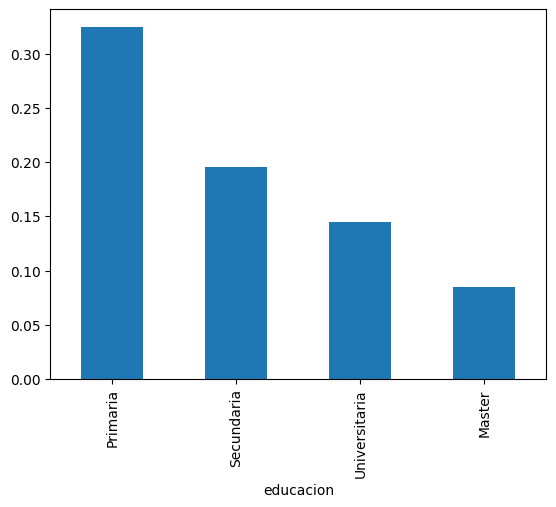

In [14]:
temp = df.groupby("educacion").abandono.mean().sort_values(ascending=False)
temp.plot.bar();

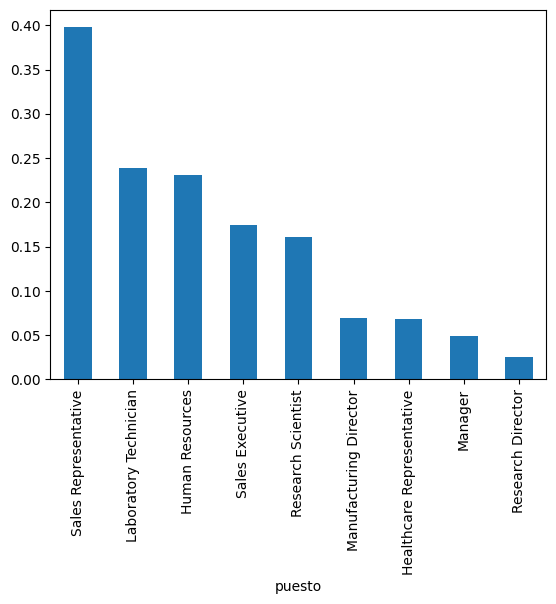

In [15]:
temp = df.groupby("puesto").abandono.mean().sort_values(ascending=False)
temp.plot.bar();

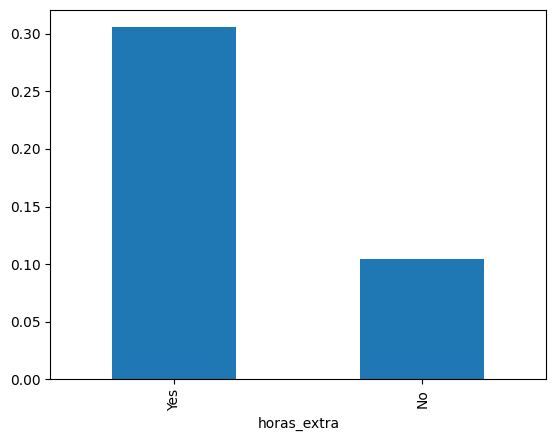

In [16]:
temp = df.groupby("horas_extra").abandono.mean().sort_values(ascending=False)

temp.plot.bar();

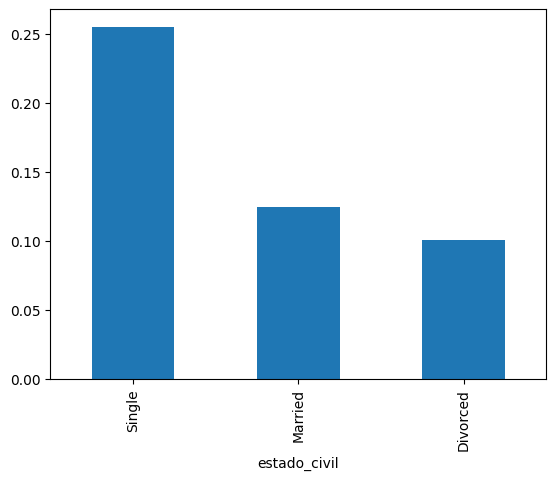

In [17]:
temp = df.groupby("estado_civil").abandono.mean().sort_values(ascending=False)
temp.plot.bar();

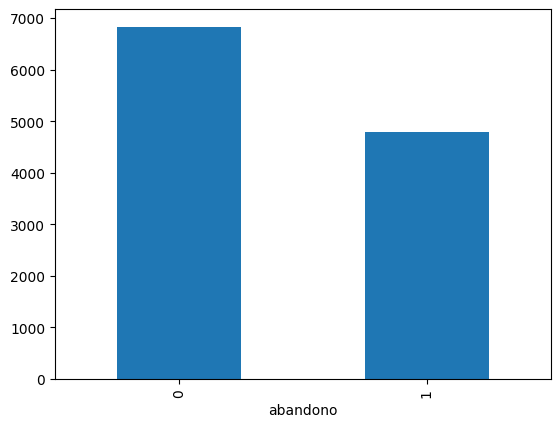

In [18]:
temp = df.groupby("abandono").salario_mes.mean()
temp.plot.bar();

Pero antes de sacar conclusiones, veamos un paneo general de todas las variables con un pairplot.

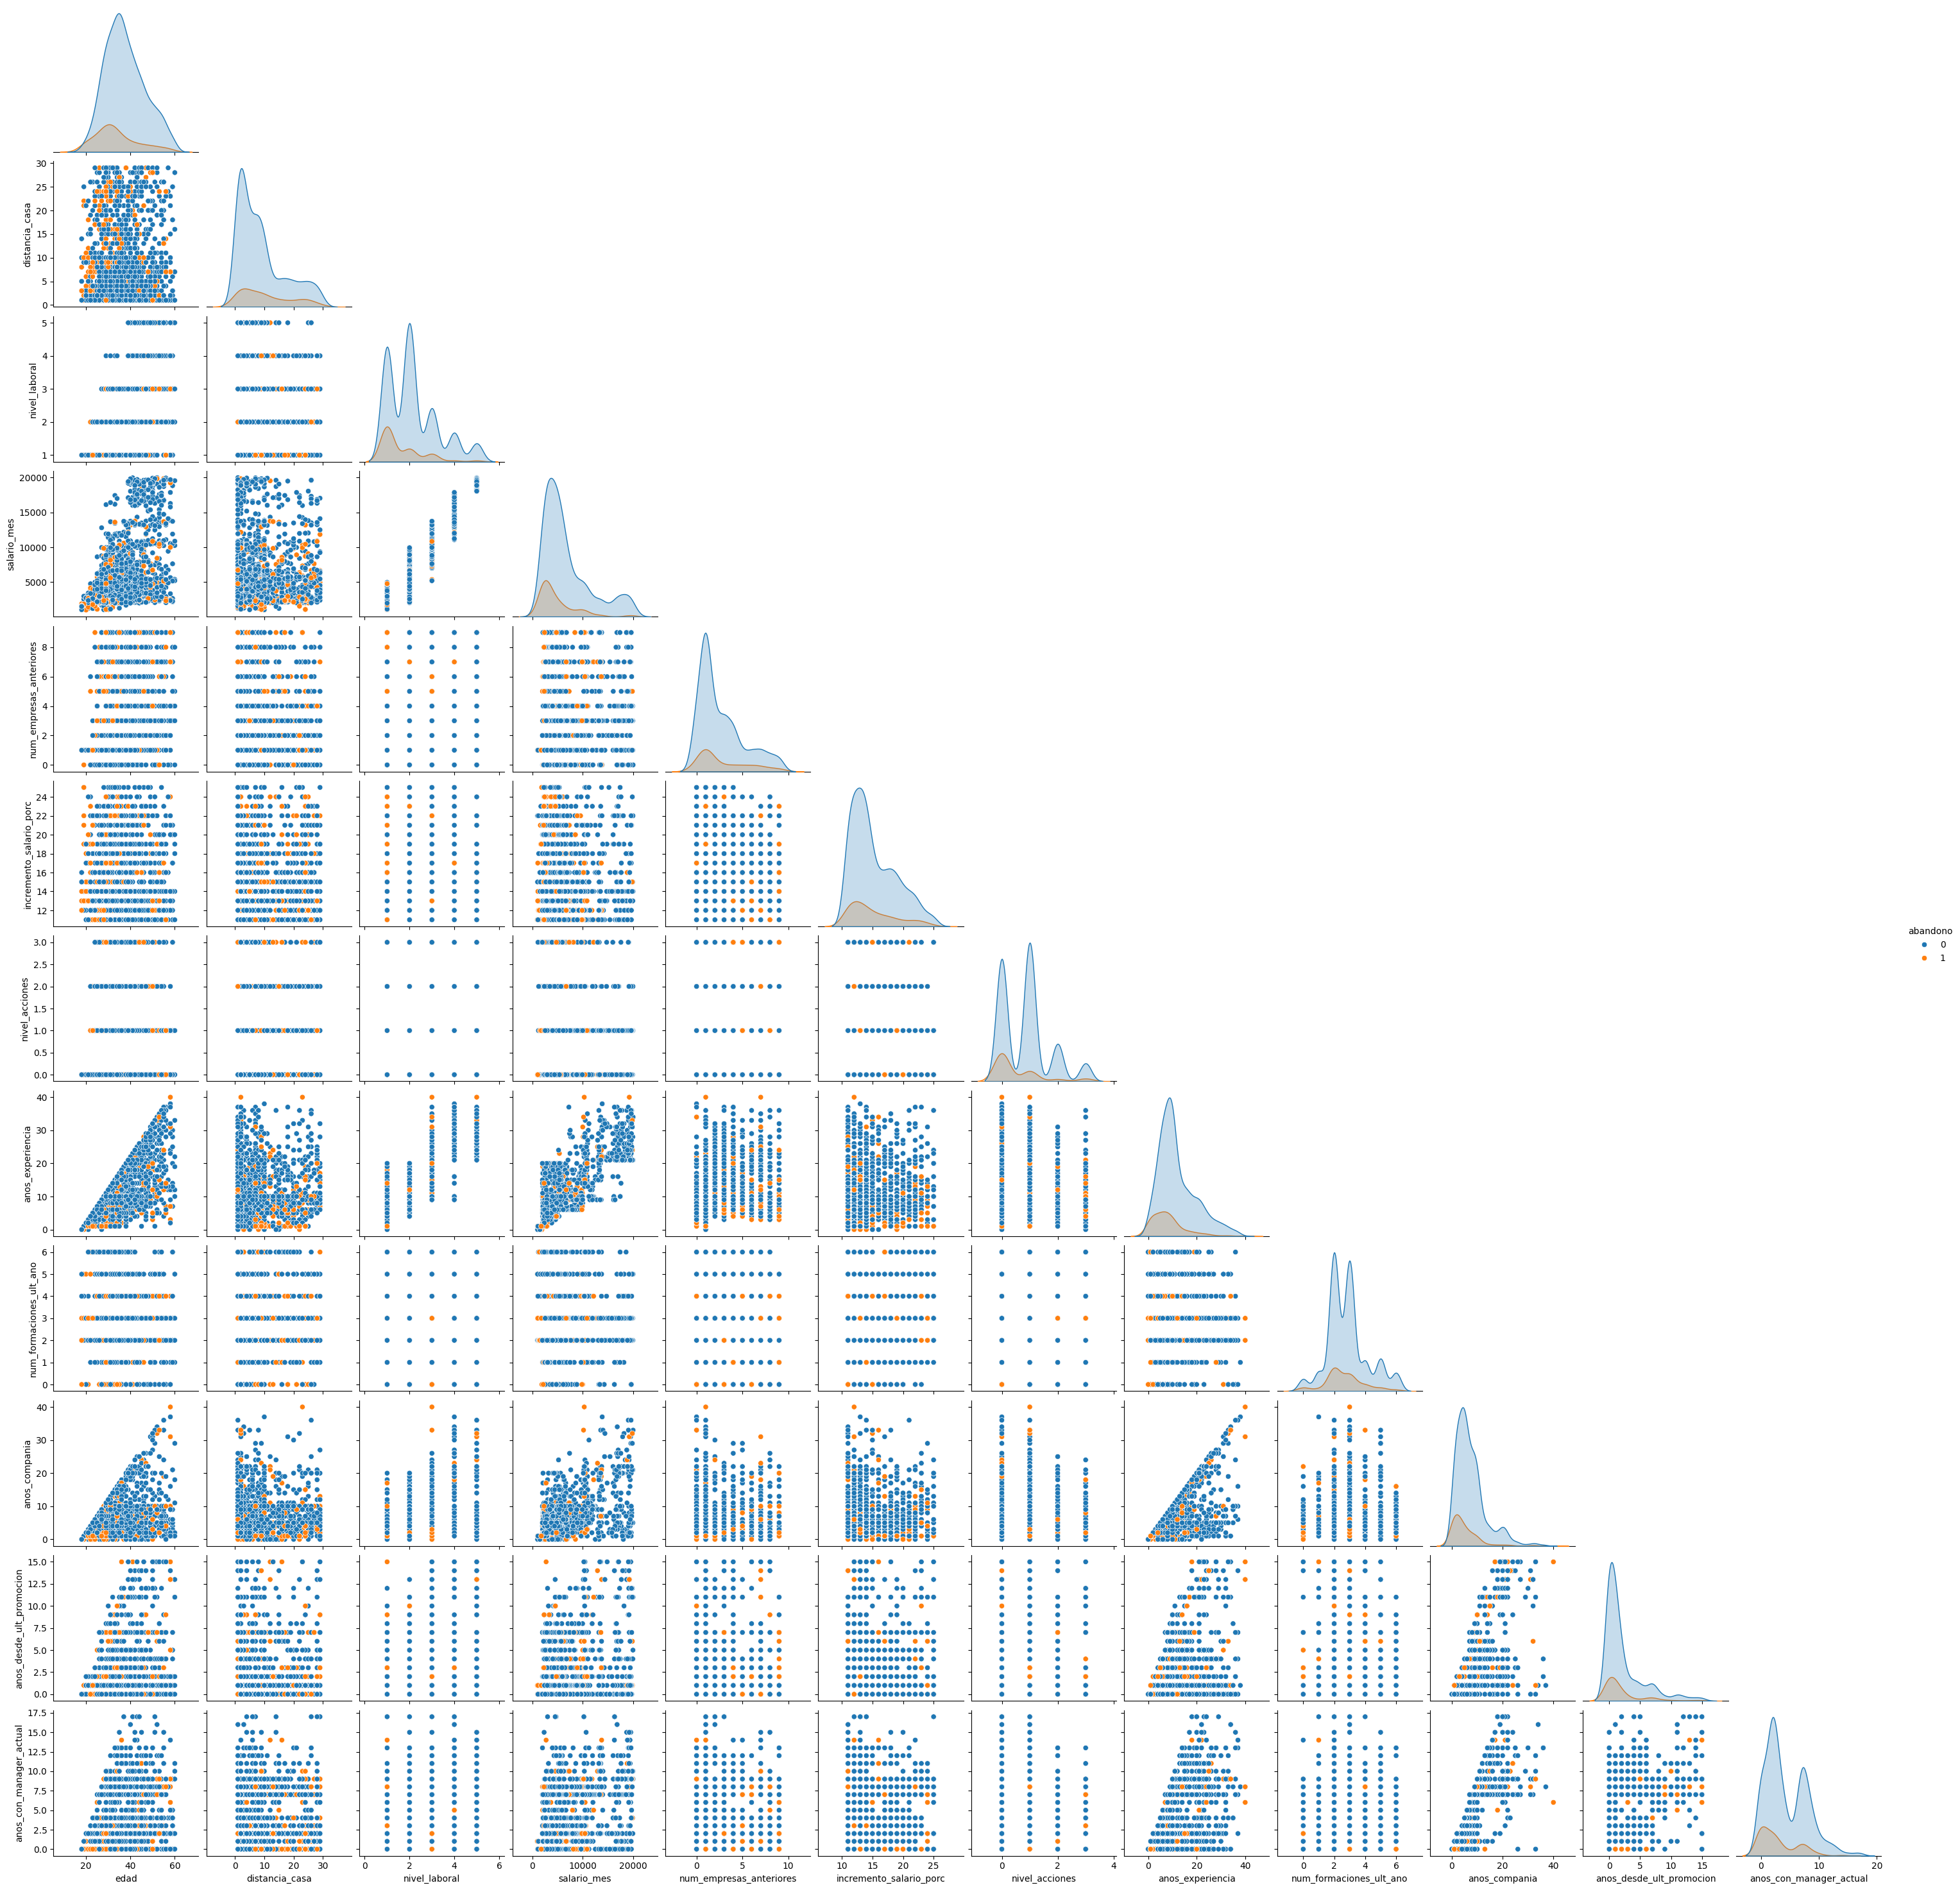

In [19]:
sb.pairplot(df, hue="abandono", corner=True, diag_kind="kde")

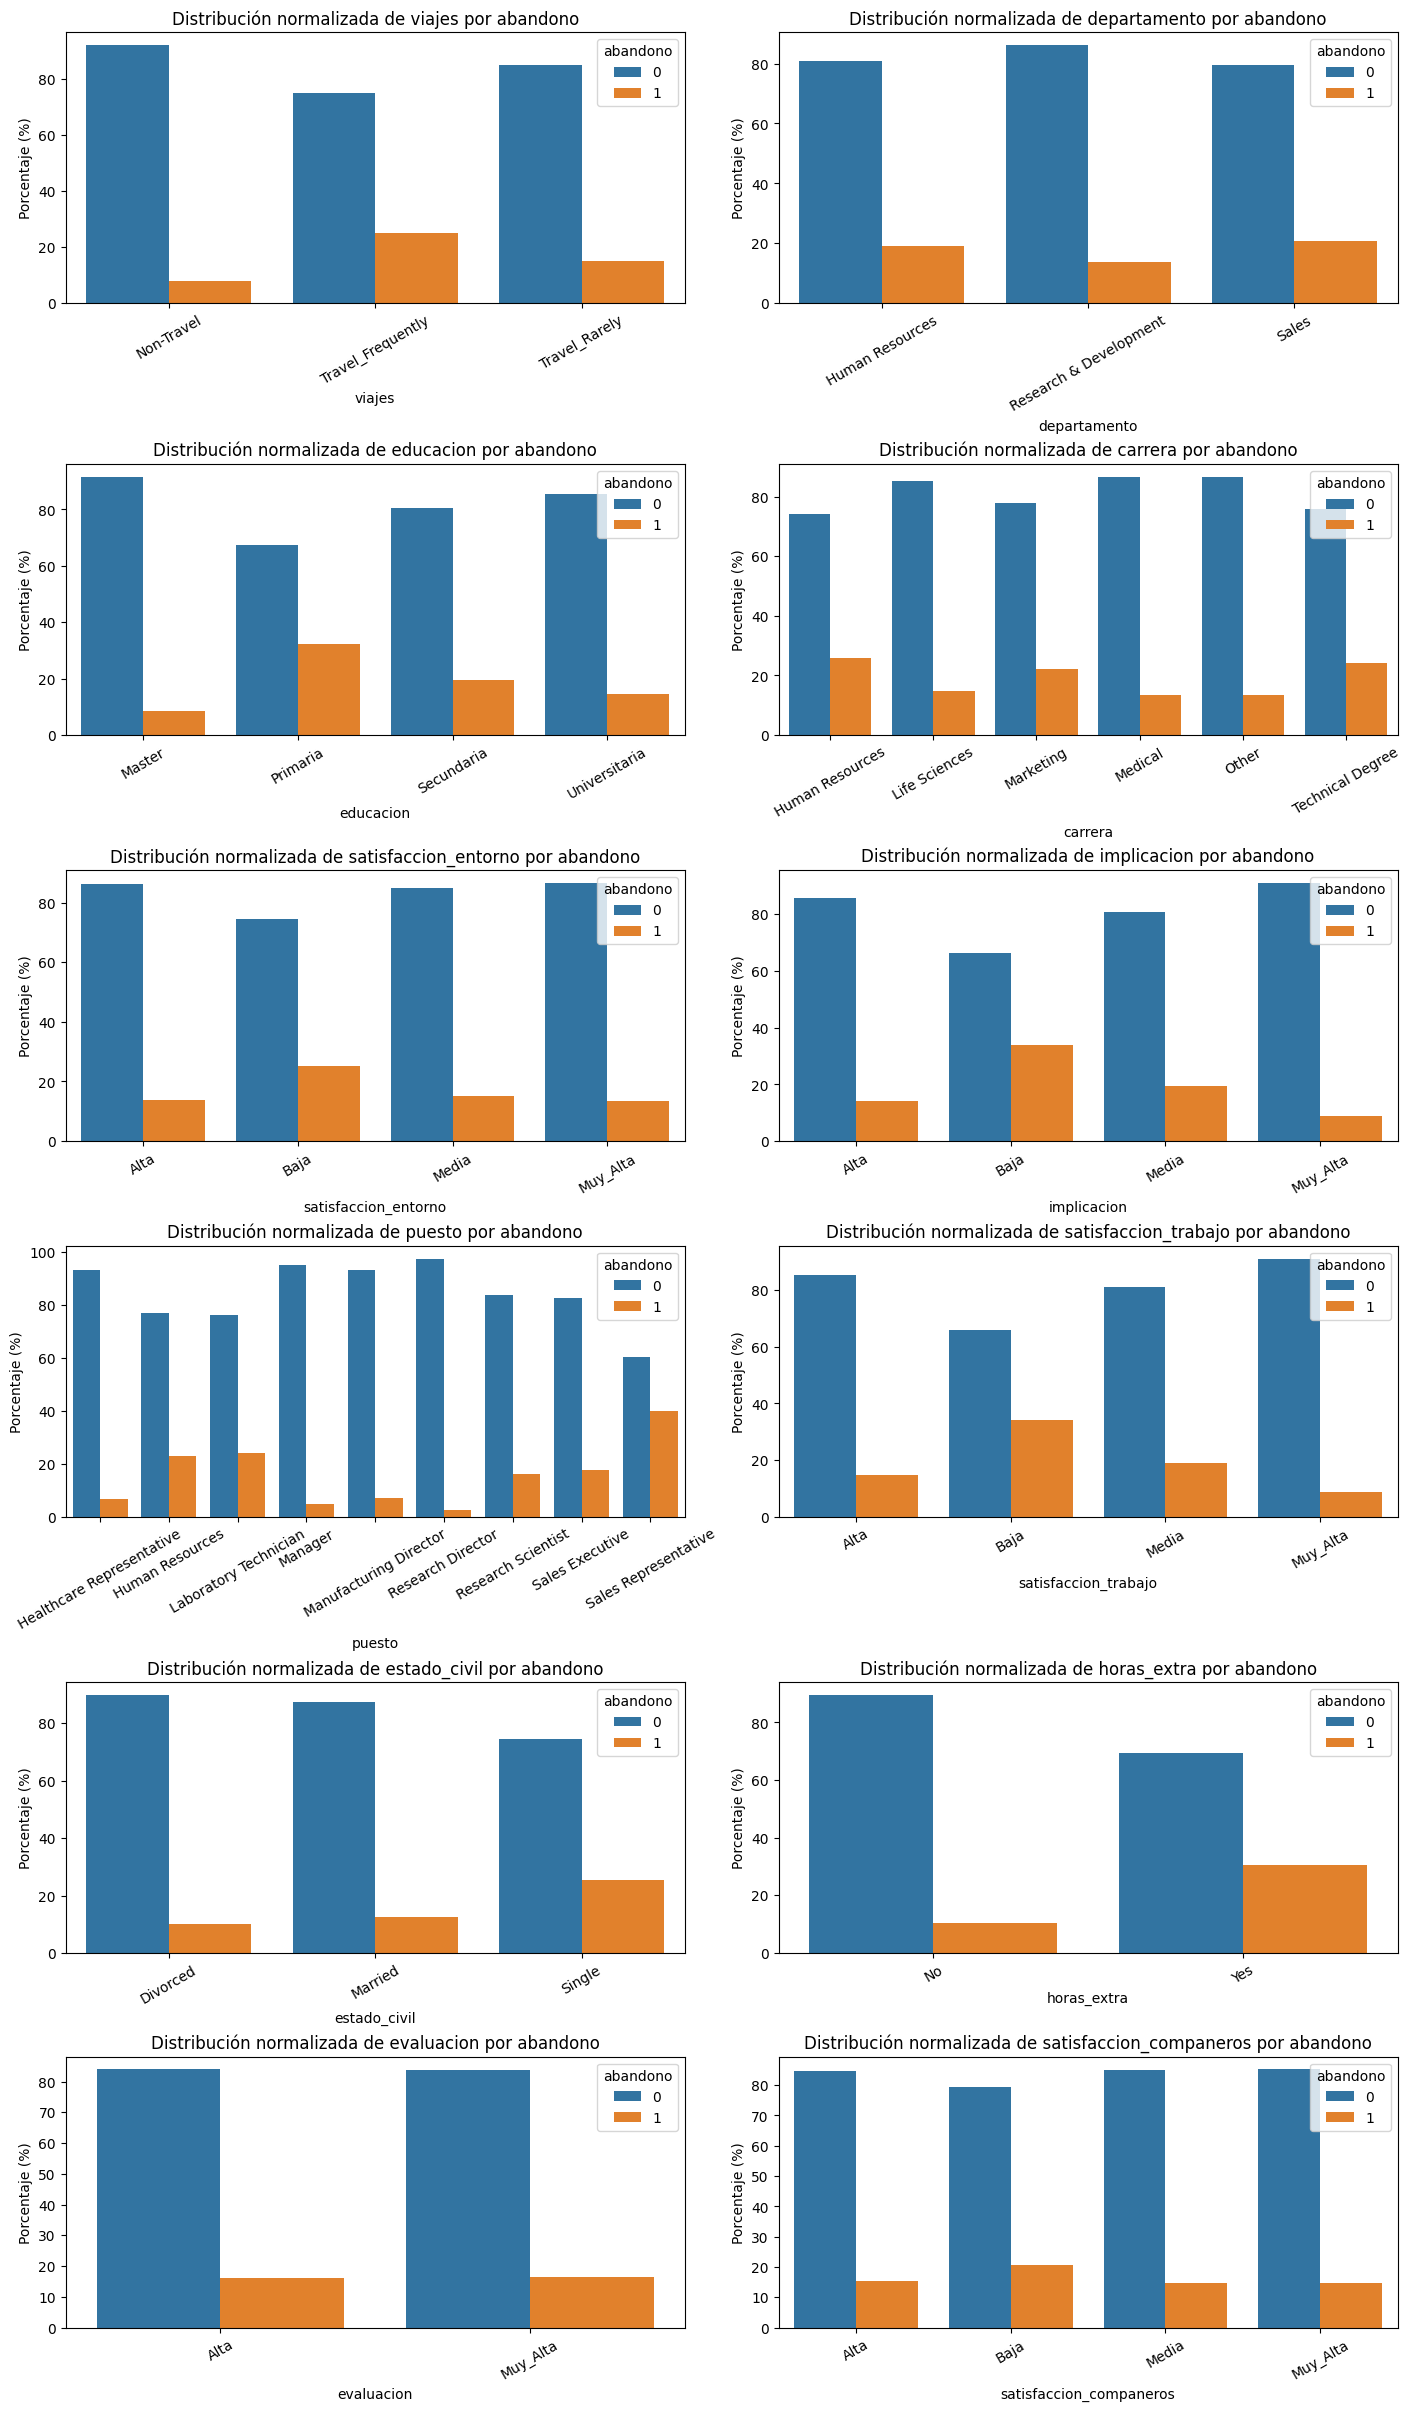

In [20]:
def plot_normalized_distribution(df, column, ax):
    tmp = df.groupby([column, "abandono"]).size().rename("conteo").reset_index()
    tmp["porcentaje"] = tmp.groupby(column)["conteo"].transform(lambda s: s / s.sum() * 100)

    sb.barplot(data=tmp, x=column, y="porcentaje", hue="abandono", ax=ax)
    ax.set_title(f"Distribución normalizada de {column} por abandono")
    ax.set_ylabel("Porcentaje (%)")
    ax.set_xlabel(column)
    ax.tick_params(axis="x", rotation=30)
    ax.legend(title="abandono", loc="best")


cols = df.select_dtypes("object").columns
n = len(cols)
ncols = 2
nrows = (n + 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows), constrained_layout=True)
axes = axes.flatten()

for ax, c in zip(axes, cols):
    plot_normalized_distribution(df, c, ax)

# Rremuevo axes extra.
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.show()

**Conclusión**
* En cuanto a variables numericas a priori no existe combinacion que haga a la renuncia.
* Perfil medio del empleado que deja la empresa:
    * Viaja frecuentemente.
    * Departamento de ventas y recursos humanos.
    * Trabaja como representativo de ventas, seguido de healthcare y HR.
    * Bajo nivel educativo.
    * Baja implicación (comprometido con la empresa)
    * Poco satisfecho con su trabajo.
    * Soltero.
    * Alta carga de horas extra.
    * Bajo salario.


### ¿Cual es el impacto económico de este problema?

Seún el estudio "Cost of Turnover" del Center for American Porgress:

* El coste de la fuga de los empleados que ganan menos de 30k es de 16.1% de su salaio.

* El coste de la fuga de los empleados que ganan entre 30k-50k es de 19.7% de su salaio.

* El coste de la fuga de los empleados que ganan entre 50k-75k es de 20.4% de su salaio.

* El coste de la fuga de los empleados que ganan mas de 75k es de 21% de su salaio

In [21]:
df["salario_anual"] = df.salario_mes*12 #estimacion
df[["salario_anual", "salario_mes"]]

salario_anual  salario_mes
id                              
1             71916         5993
2             61560         5130
4             25080         2090
5             34908         2909
7             41616         3468
...             ...          ...
2061          30852         2571
2062         119892         9991
2064          73704         6142
2065          64680         5390
2068          52848         4404

[1470 rows x 2 columns]

In [22]:
def condition(x):
    """
    El coste de la fuga de los empleados que ganan menos de 30k es de 16.1% de su salaio.

    El coste de la fuga de los empleados que ganan entre 30k-50k es de 19.7% de su salaio.

    El coste de la fuga de los empleados que ganan entre 50k-75k es de 20.4% de su salaio.

    El coste de la fuga de los empleados que ganan mas de 75k es de 21% de su salaio
    """
    if x <= 30_000:             return x*0.161
    if 30_000 < x <= 50_000:    return x*0.197
    if 50_000 < x <= 75_000:    return x*0.204
    if 75_000 < x:              return x*0.21
    else:                       return -9999

df["impacto_abandono"] = df.salario_anual.transform(condition)

df[["salario_anual", "impacto_abandono"]]

salario_anual  impacto_abandono
id                                   
1             71916         14670.864
2             61560         12558.240
4             25080          4037.880
5             34908          6876.876
7             41616          8198.352
...             ...               ...
2061          30852          6077.844
2062         119892         25177.320
2064          73704         15035.616
2065          64680         13194.720
2068          52848         10780.992

[1470 rows x 2 columns]

### ¿Cuanto de se pierde este último año?

In [23]:
coste_total = df[df.abandono==1].impacto_abandono.sum()
print("Cada año nos está costando:", coste_total)

Cada año nos está costando: 2719005.912


### ¿Cuanto nos cuestan los empleados no motivados?

In [24]:
costo_total_fuga =   df[(df.abandono==1) & (df.implicacion=='Baja')].impacto_abandono.sum()
print("Cada año nos está costando:",costo_total_fuga)


Cada año nos está costando: 368672.688


#

¿Cuanto nos ahorrariamos fidelizando a nuestros empleados?

In [25]:
print(f"Reducir el 10% ahorra un {int(coste_total * 0.10)} cada año")

print(f"Reducir el 20% ahorra un {int(coste_total * 0.20)} cada año")

print(f"Reducir el 30% ahorra un {int(coste_total * 0.30)} cada año")

Reducir el 10% ahorra un 271900 cada año
Reducir el 20% ahorra un 543801 cada año
Reducir el 30% ahorra un 815701 cada año


Y se pueden saeguir proponiendo estrategias.

Se puede averiguar de la gente de ventas cuando creemos que se van a ir, en base a eso cuanto ahorrariamos de mantenerlos.

In [26]:
#veamos cuantos se fueron el ultimo año
porc_ventas_anio = ((df.puesto == "Sales Representative") & (df.abandono==1)).sum() / (df.puesto == "Sales Representative").sum()

print(f"porcentaje de ventas que abandonaron: {porc_ventas_anio:.02}")


gente_ventas_actuales = (df.puesto == "Sales Representative") & (df.abandono==0)
cant_pred_fugados = (porc_ventas_anio*gente_ventas_actuales.sum())

print(f"Quedan {cant_pred_fugados} empleados de ventas")


quedan = cant_pred_fugados*0.3 #salvamos al 30%
ahorro = df.impacto_abandono[gente_ventas_actuales].sum()*porc_ventas_anio*0.3 #(sobreviven)*salvo

print(f"quedan {int(quedan)} y me ahorro {ahorro}$ anuales")

porcentaje de ventas que abandonaron: 0.4
Quedan 19.879518072289155 empleados de ventas
quedan 5 y me ahorro 37447.22424578312$ anuales


# Modelado - Machine Learning

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

from xgboost.sklearn import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [28]:
df_ml = df.copy()
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 2068
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1470 non-null   int64  
 1   abandono                  1470 non-null   int64  
 2   viajes                    1470 non-null   object 
 3   departamento              1470 non-null   object 
 4   distancia_casa            1470 non-null   int64  
 5   educacion                 1470 non-null   object 
 6   carrera                   1470 non-null   object 
 7   satisfaccion_entorno      1470 non-null   object 
 8   implicacion               1470 non-null   object 
 9   nivel_laboral             1470 non-null   int64  
 10  puesto                    1470 non-null   object 
 11  satisfaccion_trabajo      1470 non-null   object 
 12  estado_civil              1470 non-null   object 
 13  salario_mes               1470 non-null   int64  
 14  num_empresas_

## Preparación de datos.

### Transformacion a variables numericas

In [29]:


cat_columns = df_ml.select_dtypes("object").columns.tolist()

ohe = OneHotEncoder(sparse_output=True, drop = "if_binary" )
ct = ColumnTransformer([
                        ("encoder" , ohe, cat_columns)
                        ],remainder="passthrough")

pipe = Pipeline([("preprocessing", ct)])

encoder = pipe.fit_transform(df_ml)
encoder

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 5.0000000e+00,
        7.1916000e+04, 1.4670864e+04],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 7.0000000e+00,
        6.1560000e+04, 1.2558240e+04],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        2.5080000e+04, 4.0378800e+03],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 3.0000000e+00,
        7.3704000e+04, 1.5035616e+04],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 8.0000000e+00,
        6.4680000e+04, 1.3194720e+04],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 2.0000000e+00,
        5.2848000e+04, 1.0780992e+04]])

In [32]:
pipe

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['viajes', 'departamento',
                                                   'educacion', 'carrera',
                                                   'satisfaccion_entorno',
                                                   'implicacion', 'puesto',
                                                   'satisfaccion_trabajo',
                                                   'estado_civil',
                                                   'horas_extra', 'evaluacion',
                                                   'satisfaccion_companeros'])]))])

## Diseño del modelo.

### Separación de sets de datos (train/test)

In [30]:

X = df_ml.drop(columns="abandono")
y = df_ml["abandono"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### Modelo

#### Arbol de despidos

In [31]:
tree = DecisionTreeClassifier(max_depth=5)

pipe = Pipeline([
    ("preprocessing", ct),
    ("tree", tree)
                 ])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['viajes', 'departamento',
                                                   'educacion', 'carrera',
                                                   'satisfaccion_entorno',
                                                   'implicacion', 'puesto',
                                                   'satisfaccion_trabajo',
                                                   'estado_civil',
                                                   'horas_extra', 'evaluacion',
                                                   'satisfaccion_companeros'])])),
                ('tree', DecisionTreeClassifier(max_depth=5))])

In [32]:
print(X_train.shape)
print(pipe.named_steps["preprocessing"].fit_transform(X_train).shape)


(1029, 26)
(1029, 60)


In [33]:
pred = pipe.predict_proba(X_test)[:,1]
pred[:10]

array([0.16      , 0.11707317, 0.04522613, 0.04522613, 0.11707317,
       0.01492537, 0.11707317, 0.09677419, 0.16      , 0.10769231])

auc: 0.6608869432813096


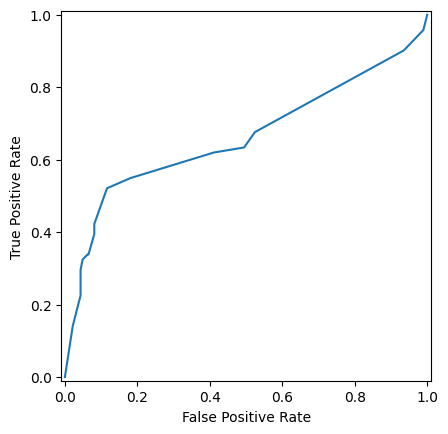

In [34]:
fpr, tpr, thresholds = roc_curve(y_test.values, pred)

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


print(f"auc: {roc_auc_score(y_test.values, pred)}") # mayor a 0.7 es bueno.

Normalmente un modelo con auc > 0.7 o 0.8 es considerado bueno.
El modelo de random classifier tiene un auc de 0.69, por lo que no es bueno pero varia alrededor de 0.7 dependiendo la corrida.
puede que los datos no sean suficientes para entrenar un modelo bueno pero es mejor probar con otros modelos un poco mas complejos.

#### Random Forest


auc: 0.7952417205938332


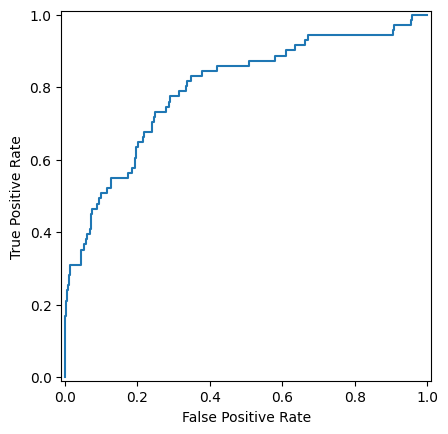

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler



cat_columns = df_ml.select_dtypes("object").columns.tolist()
num_columns = df_ml.drop(columns="abandono").select_dtypes("number").columns.tolist()
rfc   = RandomForestClassifier(max_depth=9, n_estimators=50)

ohe = OneHotEncoder(sparse_output=True, drop = "if_binary" )
ct = ColumnTransformer([
                        ("scaler", StandardScaler(), num_columns),
                        ("encoder" , ohe, cat_columns)
                        ],remainder="passthrough")


pipeline = Pipeline(steps=[
    ('preprocessing', ct), 
    ('classifier'   , rfc)])

pipeline.fit(X_train, y_train)

pred2 = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test.values, pred2)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


print(f"auc: {roc_auc_score(y_test.values, pred2)}") # mayor a 0.7 es bueno.


#### [XGBoost](https://xgboost.readthedocs.io/en/stable/r_docs/R-package/docs/reference/xgb.params.html#arg-objective) LIGHTGBM CATBOOST

In [ ]:
import scipy.stats as st
one_to_left = st.beta(10, 1) # Esta distribución nos dará valores entre 0 y 1 mayormente cercanos a 1

# este diccionario de parámetros lo vamos a usar tanto para XGBoost como para LightGBM
params = {  
    "classifier__n_estimators"  : st.randint(10,150),     # n. de árboles.
    "classifier__max_depth"     : st.randint(3, 12),      # máxima profundiad del árbol
    "classifier__learning_rate" : st.uniform(0.05, 0.1),  # learning rate (xgb’s “eta”)
    "classifier__colsample_bytree": one_to_left,          # ratio de la muestra de las columnas a la hora de construir el árbol
    "classifier__subsample"     : one_to_left,            # ratio de la muestra de las observaciones
    'classifier__reg_alpha'     : st.uniform(0.05,10),    # término de regularización L1
    "classifier__min_child_weight": st.uniform(1,20),     # Suma mínima del peso de la instancia (hessiano) requerida en los hijos
}


In [70]:
feature_names = ct.get_feature_names_out()
print("Nombres de características después de la transformación:", feature_names)

Nombres de características después de la transformación: ['scaler__edad' 'scaler__distancia_casa' 'scaler__nivel_laboral'
 'scaler__salario_mes' 'scaler__num_empresas_anteriores'
 'scaler__incremento_salario_porc' 'scaler__nivel_acciones'
 'scaler__anos_experiencia' 'scaler__num_formaciones_ult_ano'
 'scaler__anos_compania' 'scaler__anos_desde_ult_promocion'
 'scaler__anos_con_manager_actual' 'scaler__salario_anual'
 'scaler__impacto_abandono' 'encoder__viajes_Non-Travel'
 'encoder__viajes_Travel_Frequently' 'encoder__viajes_Travel_Rarely'
 'encoder__departamento_Human Resources'
 'encoder__departamento_Research & Development'
 'encoder__departamento_Sales' 'encoder__educacion_Master'
 'encoder__educacion_Primaria' 'encoder__educacion_Secundaria'
 'encoder__educacion_Universitaria' 'encoder__carrera_Human Resources'
 'encoder__carrera_Life Sciences' 'encoder__carrera_Marketing'
 'encoder__carrera_Medical' 'encoder__carrera_Other'
 'encoder__carrera_Technical Degree' 'encoder__satisfacc

In [79]:
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['edad', 'distancia_casa',
                                                   'nivel_laboral',
                                                   'salario_mes',
                                                   'num_empresas_anteriores',
                                                   'incremento_salario_porc',
                                                   'nivel_acciones',
                                                   'anos_experiencia',
                                                   'num_formaciones_ult_ano',
                                                   'anos_compania',
                                                   'anos_desde_ult_promocion',
                                                   'anos_con_manager_actual',
                                                   'salario_anual',
                                                   'impacto_abandono']),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['viajes', 'departamento',
                                                   'educacion', 'carrera',
                                                   'satisfaccion_entorno',
                                                   'implicacion', 'puesto',
                                                   'satisfaccion_trabajo',
                                                   'estado_civil',
                                                   'horas_extra', 'evaluacion',
                                                   'satisfaccion_companeros'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=9, n_estimators=50))])

In [80]:
search_space = [
    # 1) XGBoost
    {
      "classifier": [XGBClassifier(n_jobs=3, eval_metric="logloss")],
      **params,
      "classifier__gamma": st.uniform(0, 10),  # Reducción mínima de pérdida requerida para hacer un split
    },
    # 2) LightGBM
    {
      "classifier": [LGBMClassifier(n_jobs=3, verbose=-1)],
      **params,
      "preprocessing__unknown_value": [np.nan, 99999999]
    },
    # 3) CatBoost
    {
      "classifier": [CatBoostClassifier(thread_count=3, verbose=False)],
      "classifier__n_estimators": st.randint(10, 150),           # Número de árboles
      "classifier__max_depth": st.randint(3, 12),                # Profundidad máxima del árbol
      "classifier__learning_rate": st.uniform(0.05, 0.1),        # Tasa de aprendizaje
      "classifier__subsample": one_to_left,                      # Proporción de muestreo de observaciones
    },
    # 4) Regresión logística
    {
      "classifier": [LogisticRegression(max_iter=5_000)],
      "classifier__C": [10**x for x in range(-5, 3)],            # Fuerza de regularización (inversa)
    }
]

In [81]:
model = RandomizedSearchCV(pipeline, search_space, n_iter=100, verbose=1, cv=3)
model.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


ValueError: Invalid parameter 'unknown_value' for estimator ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['edad', 'distancia_casa', 'nivel_laboral',
                                  'salario_mes', 'num_empresas_anteriores',
                                  'incremento_salario_porc', 'nivel_acciones',
                                  'anos_experiencia', 'num_formaciones_ult_ano',
                                  'anos_compania', 'anos_desde_ult_promocion',
                                  'anos_con_manager_actual', 'salario_anual',
                                  'impacto_abandono']),
                                ('encoder', OneHotEncoder(drop='if_binary'),
                                 ['viajes', 'departamento', 'educacion',
                                  'carrera', 'satisfaccion_entorno',
                                  'implicacion', 'puesto',
                                  'satisfaccion_trabajo', 'estado_civil',
                                  'horas_extra', 'evaluacion',
                                  'satisfaccion_companeros'])]). Valid parameters are: ['force_int_remainder_cols', 'n_jobs', 'remainder', 'sparse_threshold', 'transformer_weights', 'transformers', 'verbose', 'verbose_feature_names_out'].

In [50]:
model.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['viajes', 'departamento',
                                                   'educacion', 'carrera',
                                                   'satisfaccion_entorno',
                                                   'implicacion', 'puesto',
                                                   'satisfaccion_trabajo',
                                                   'estado_civil',
                                                   'horas_extra', 'evaluacion',
                                                   'satisfaccion_companeros'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.9427779165413352,
                                learning_rate=0.1293257359732221, max_depth=9,
                                min_child_weight=12.278993967328114,
                                n_estimators=88, n_jobs=3,
                                reg_alpha=1.2397886475322994,
                                subsample=0.9830880568357456, verbose=-1))])

In [51]:
results = pd.DataFrame(model.cv_results_)
results


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.018102      0.001068         0.005929        0.000489   
1        2.038778      0.225838         0.007112        0.000722   
2        0.031201      0.026187         0.006208        0.000548   
3        0.016565      0.000636         0.005286        0.000639   
4        0.068126      0.003301         0.005991        0.001292   
..            ...           ...              ...             ...   
95       0.031211      0.027028         0.006209        0.000760   
96       0.014752      0.000444         0.005797        0.000590   
97       0.076941      0.001877         0.004896        0.000267   
98       0.018449      0.001254         0.005466        0.000410   
99       0.024887      0.001330         0.005653        0.000914   

                                     param_classifier  \
0                LGBMClassifier(n_jobs=3, verbose=-1)   
1                   LogisticRegression(max_iter=5000)   
2                LGBMClassifier(n_jobs=3, verbose=-1)   
3   XGBClassifier(base_score=None, booster=None, c...   
4   CatBoostClassifier(thread_count=3, verbose=False)   
..                                                ...   
95               LGBMClassifier(n_jobs=3, verbose=-1)   
96               LGBMClassifier(n_jobs=3, verbose=-1)   
97  CatBoostClassifier(thread_count=3, verbose=False)   
98  XGBClassifier(base_score=None, booster=None, c...   
99  XGBClassifier(base_score=None, booster=None, c...   

    param_classifier__colsample_bytree  param_classifier__learning_rate  \
0                             0.858421                         0.127506   
1                                  NaN                              NaN   
2                             0.827878                         0.093463   
3                             0.759501                         0.145526   
4                                  NaN                         0.088424   
..                                 ...                              ...   
95                            0.950050                         0.107595   
96                            0.973879                         0.074975   
97                                 NaN                         0.105818   
98                            0.855405                         0.135654   
99                            0.931785                         0.071593   

    param_classifier__max_depth  param_classifier__min_child_weight  \
0                           8.0                           16.808984   
1                           NaN                                 NaN   
2                           6.0                           10.646588   
3                           9.0                           10.888901   
4                           3.0                                 NaN   
..                          ...                                 ...   
95                          7.0                           15.824446   
96                          6.0                           12.039768   
97                          5.0                                 NaN   
98                          8.0                           20.453873   
99                          6.0                            5.197881   

    param_classifier__n_estimators  ...  param_classifier__subsample  \
0                            119.0  ...                     0.987328   
1                              NaN  ...                          NaN   
2                             29.0  ...                     0.962936   
3                             53.0  ...                     0.970274   
4                            137.0  ...                     0.806119   
..                             ...  ...                          ...   
95                            10.0  ...                     0.997331   
96                            66.0  ...                     0.857858   
97                           105.0  ...                     0.976114   
98                          

auc: 0.772173582032737


/home/brian/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


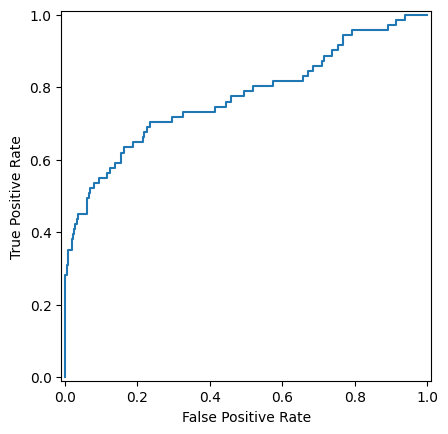

In [52]:
lgbm_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test.values, lgbm_pred)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


print(f"auc: {roc_auc_score(y_test.values, lgbm_pred)}") # mayor a 0.7 es bueno.

## Interpretación

Veamos el diagrama del arbol (lo bueno de un solo arbol es que se puede interpretar)

Al final el mejor modelo fue el de LightGBM pero interpretar los arboles es dificil asi que solo se usa un solo arbol para tener intuición, el primer modelo.

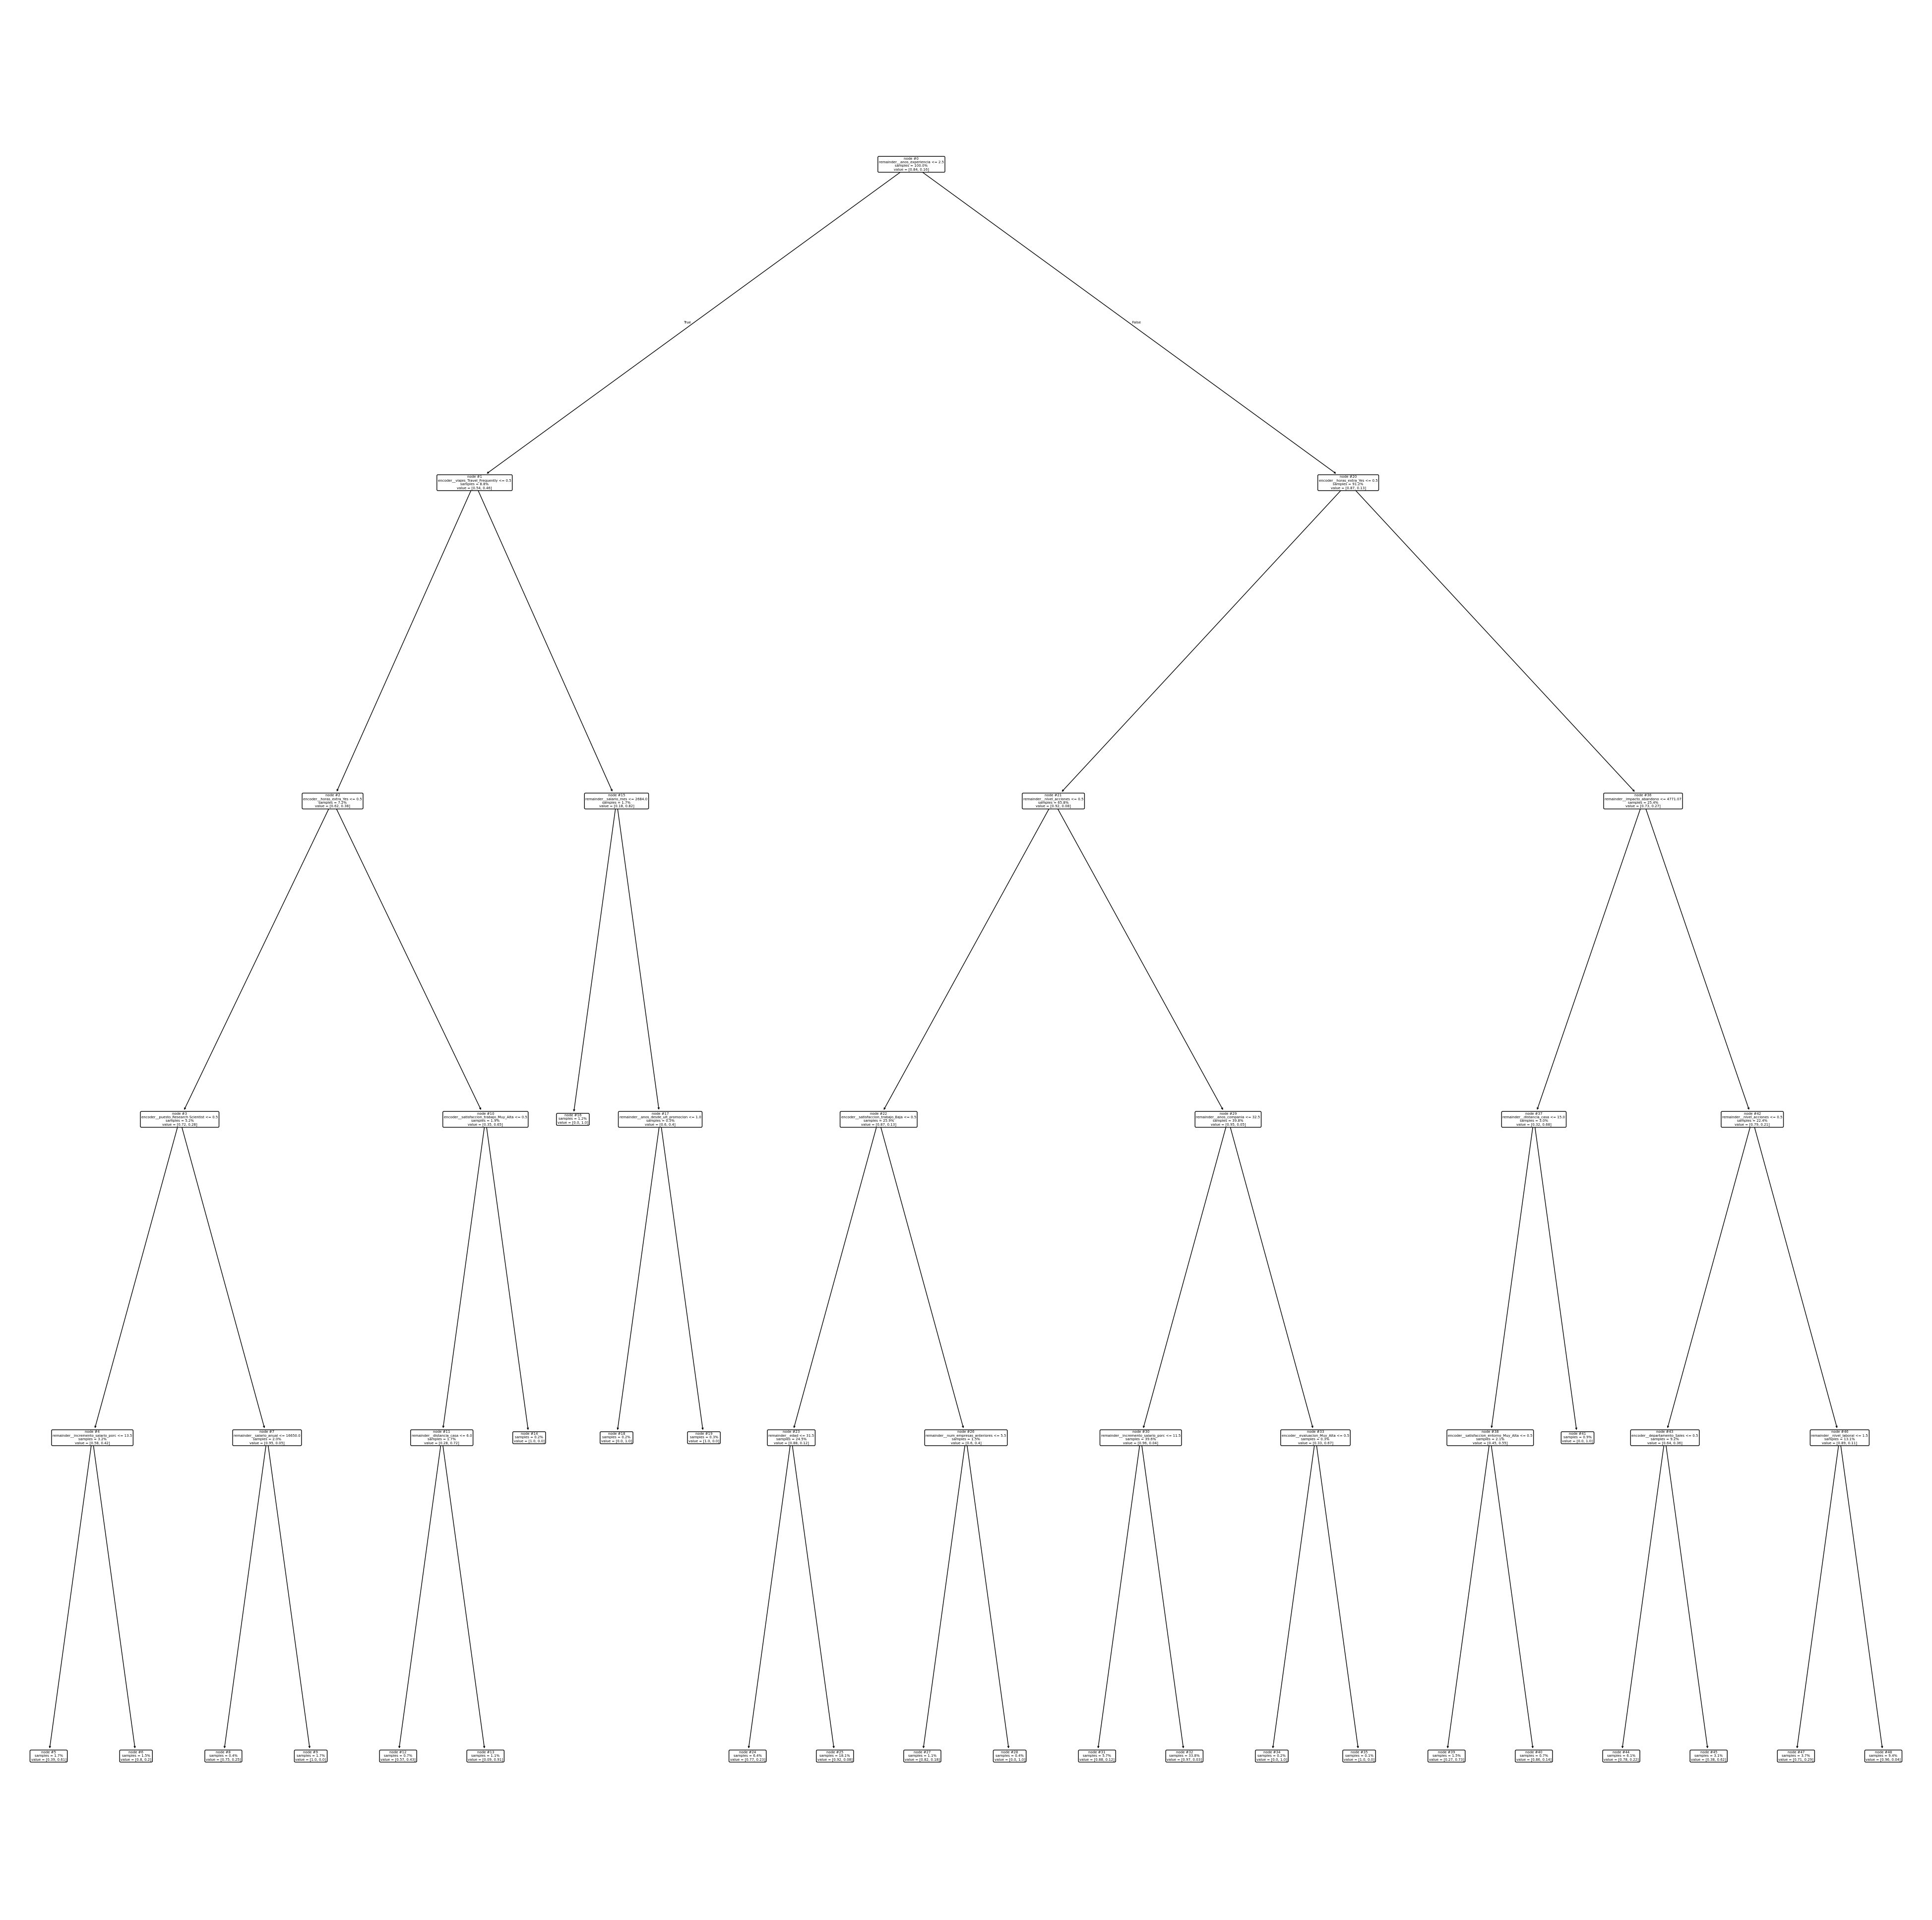

In [55]:
features_name = pipe.named_steps["preprocessing"].get_feature_names_out()
plt.figure(figsize=(50,50))

plot_tree(tree,
          feature_names = features_name,
          impurity      = False,
          node_ids      = True,
          proportion    = True,
          rounded       = True,
          precision     = 2);

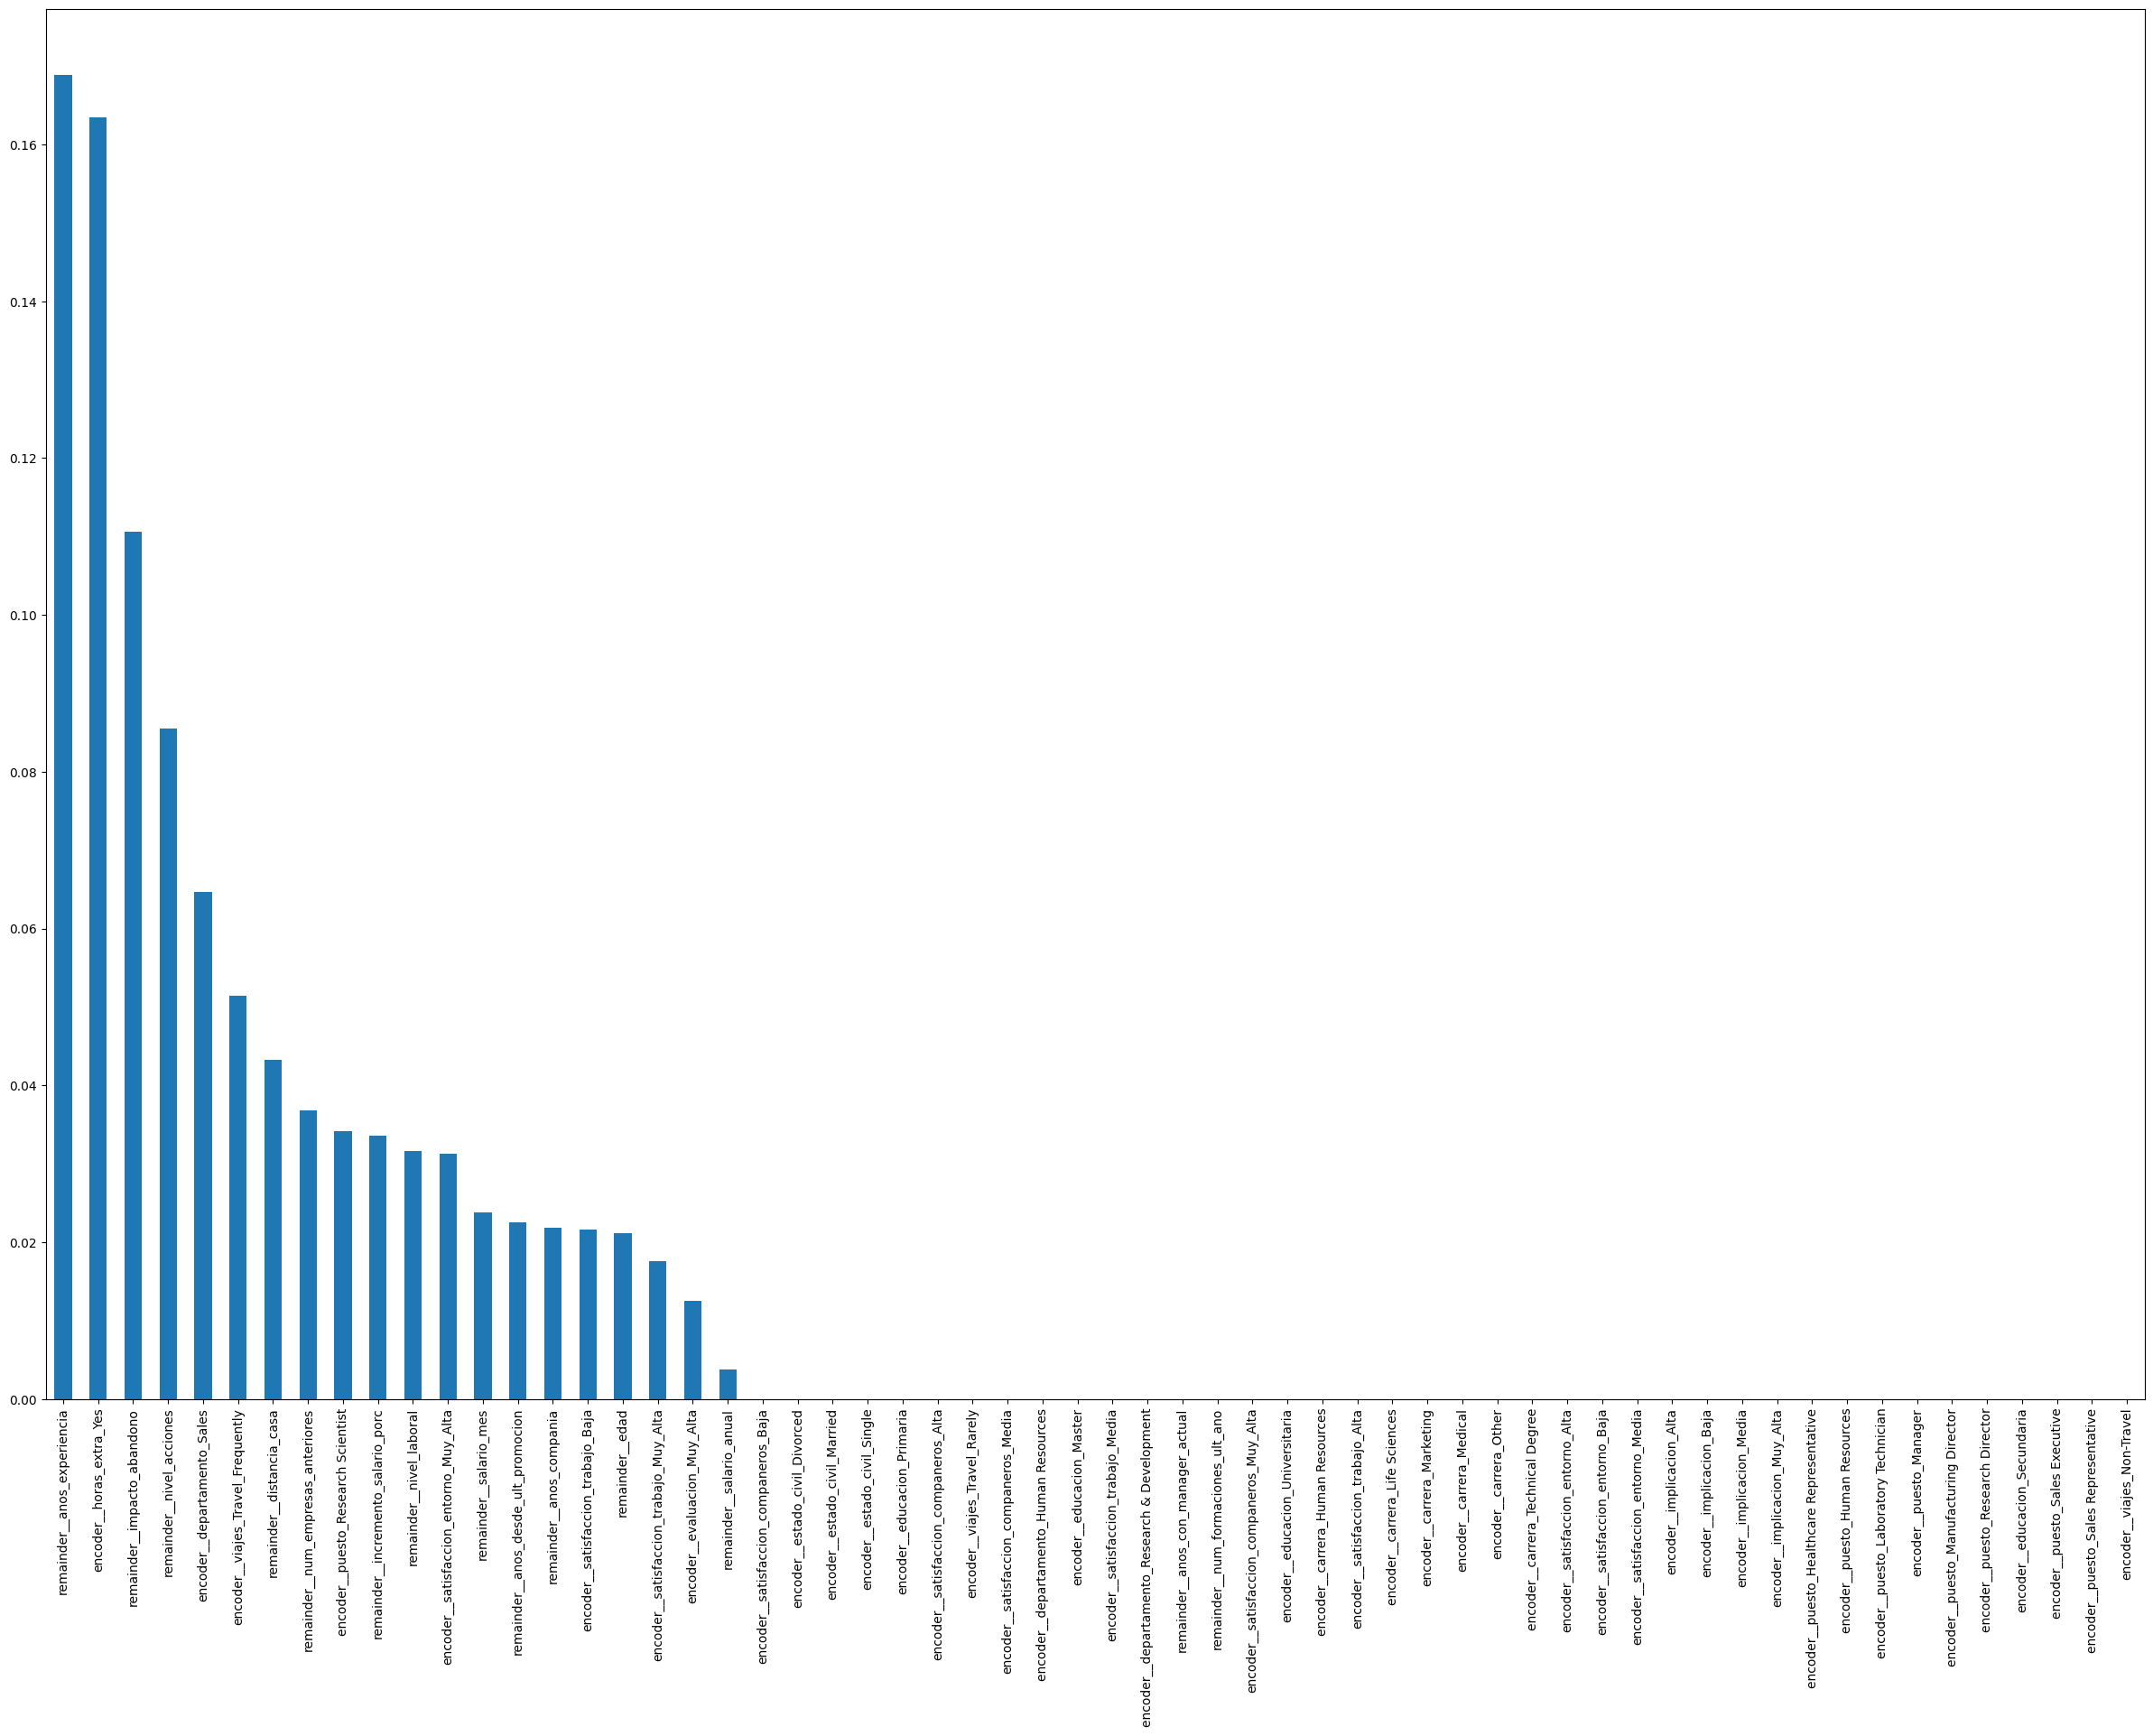

In [56]:
pd.Series(tree.feature_importances_, index=features_name).sort_values(ascending=False).plot(kind='bar', figsize=(30,20));

Vemos que solo hay unas pocas featrures que realmente tienen importancia para prevenir y predecir abandono.

Solo nos deberiamos concentrar en ellas

## Explotación

In [ ]:
df["scoring_abandono"] = model.predict_proba(df_ml.drop(columns="abandono"))[:,1]
df

/home/brian/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


edad  abandono             viajes            departamento  \
id                                                                
1       41         1      Travel_Rarely                   Sales   
2       49         0  Travel_Frequently  Research & Development   
4       37         1      Travel_Rarely  Research & Development   
5       33         0  Travel_Frequently  Research & Development   
7       27         0      Travel_Rarely  Research & Development   
...    ...       ...                ...                     ...   
2061    36         0  Travel_Frequently  Research & Development   
2062    39         0      Travel_Rarely  Research & Development   
2064    27         0      Travel_Rarely  Research & Development   
2065    49         0  Travel_Frequently                   Sales   
2068    34         0      Travel_Rarely  Research & Development   

      distancia_casa      educacion        carrera satisfaccion_entorno  \
id                                                                        
1                  1  Universitaria  Life Sciences                Media   
2                  8     Secundaria  Life Sciences                 Alta   
4                  2     Secundaria          Other             Muy_Alta   
5                  3  Universitaria  Life Sciences             Muy_Alta   
7                  2  Universitaria        Medical                 Baja   
...              ...            ...            ...                  ...   
2061              23         Master        Medical                 Alta   
2062               6     Secundaria        Medical             Muy_Alta   
2064               4         Master  Life Sciences                Media   
2065               2     Secundaria        Medical             Muy_Alta   
2068               8  Universitaria        Medical                Media   

     implicacion  nivel_laboral  ... satisfaccion_companeros nivel_acciones  \
id                               ...                                          
1           Alta              2  ...                    Baja              0   
2          Media              2  ...                Muy_Alta              1   
4          Media              1  ...                   Media              0   
5           Alta              1  ...                    Alta              0   
7           Alta              1  ...                Muy_Alta              1   
...          ...            ...  ...                     ...            ...   
2061    Muy_Alta              2  ...                    Alta              1   
2062       Media              3  ...                    Baja              1   
2064    Muy_Alta              2  ...                   Media              1   
2065       Media              2  ...                Muy_Alta              0   
2068    Muy_Alta              2  ...                    Baja              0   

     anos_experiencia  num_formaciones_ult_ano  anos_compania  \
id                                                              
1                   8                        0              6   
2                  10                        3             10   
4                   7                        3              0   
5                   8                        3              8   
7                   6                        3              2   
...               ...                      ...            ...   
2061               17                        3              5   
2062                9                        5              7   
2064                6                        0              6   
2065               17                        3              9   
2068                6                        3              4   

     anos_desde_ult_promocion  anos_con_manager_actual salario_anual  \
id                                                                     
1                           0                        5         71916   
2                           1                        7         61560

Puedo obtener los topk empleados que tengan mas "probabilidad" de abandonar la empresa.

In [61]:
df["scoring_abandono"].sort_values(ascending = False).head(10)

id
1273    0.964526
478     0.949595
959     0.939791
911     0.939196
622     0.936624
1868    0.914711
614     0.913083
1939    0.909166
514     0.905790
1928    0.903435
Name: scoring_abandono, dtype: float64

OK, por puesto de trabajo

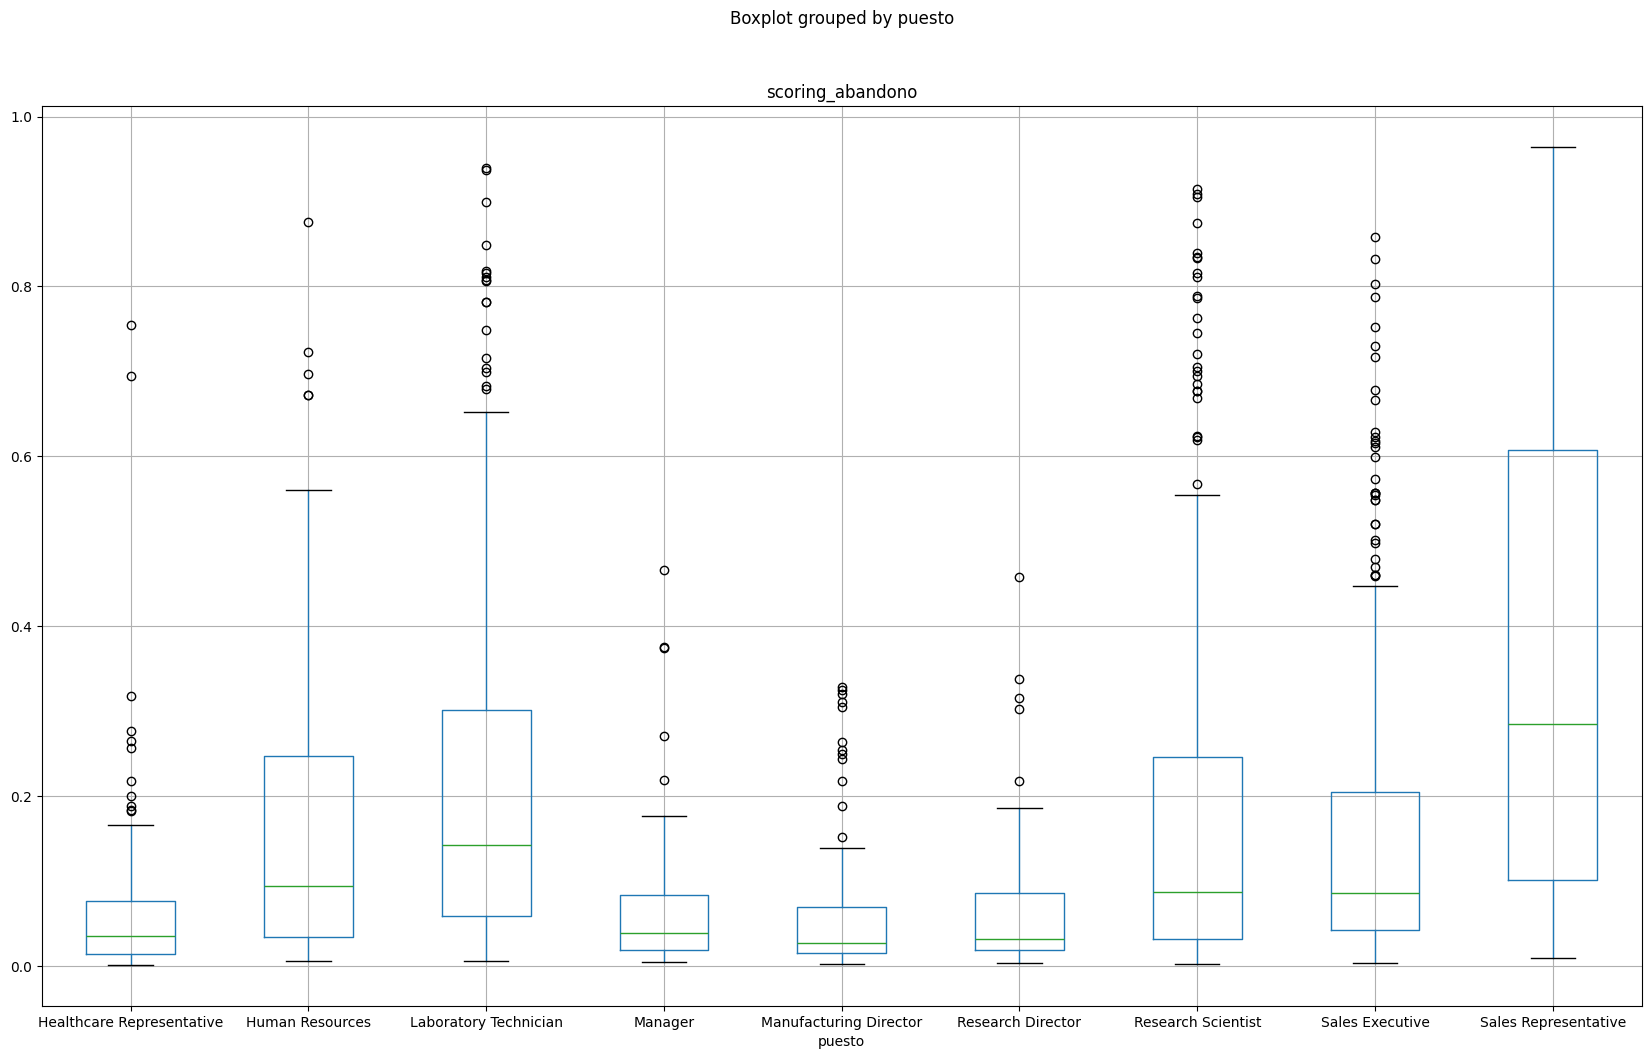

In [62]:
df.boxplot(column='scoring_abandono', by='puesto', figsize=(20,12));

In [63]:
df.to_excel("abandono_con_scoring.xlsx")